In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [4]:
import torch

In [5]:


def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

# %% 



all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# %%
# Build the names dictionary, a list of names per language
# di tionary keys are languages, values are names
names = {}
languages = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [6]:

n_categories = len(languages)

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''



# Now we have ``names``, a dictionary mapping each category
# (language) to a list of lines (names). We also kept track of
# ``languages`` (just a list of languages) and ``n_categories`` for
# later reference.
# 


In [7]:
languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [8]:
findName(names,'Johnson')

'English'

In [9]:
findName(names,'Bernal')

''

In [10]:
print(names['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [11]:





# %% 
# Turning Names into Tensors
# --------------------------
# 
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
# 
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
# 
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
# 
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.

import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(nameToTensor('Jones').size())


# %% Creating the Network
# ====================
# 
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
# 
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
# 
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:

import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 64
rnn = RNN(n_letters, n_hidden, n_categories)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [12]:
# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [13]:

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)


tensor([[-2.9601, -2.8717, -2.8840, -2.7356, -2.8437, -2.9454, -2.9197, -2.9059,
         -2.9438, -2.9657, -2.8939, -2.8821, -2.8773, -2.9998, -2.8906, -2.9638,
         -2.8343, -2.7518]], grad_fn=<LogSoftmaxBackward>)


In [14]:

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 3)


In [15]:



# We will also want a quick way to get a training example (a name and its
# language):
# 
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)


category = Spanish / name = Vela
category = Dutch / name = Smeets
category = French / name = Felix
category = Scottish / name = Cunningham
category = Chinese / name = Tsang
category = Arabic / name = Antoun
category = Arabic / name = Nazari
category = Portuguese / name = Cruz
category = English / name = Sexton
category = English / name = Gemmell


In [16]:
languages[1]

'Chinese'

In [17]:
names

{'Arabic': ['Khoury',
  'Nahas',
  'Daher',
  'Gerges',
  'Nazari',
  'Maalouf',
  'Gerges',
  'Naifeh',
  'Guirguis',
  'Baba',
  'Sabbagh',
  'Attia',
  'Tahan',
  'Haddad',
  'Aswad',
  'Najjar',
  'Dagher',
  'Maloof',
  'Isa',
  'Asghar',
  'Nader',
  'Gaber',
  'Abboud',
  'Maalouf',
  'Zogby',
  'Srour',
  'Bahar',
  'Mustafa',
  'Hanania',
  'Daher',
  'Tuma',
  'Nahas',
  'Saliba',
  'Shamoon',
  'Handal',
  'Baba',
  'Amari',
  'Bahar',
  'Atiyeh',
  'Said',
  'Khouri',
  'Tahan',
  'Baba',
  'Mustafa',
  'Guirguis',
  'Sleiman',
  'Seif',
  'Dagher',
  'Bahar',
  'Gaber',
  'Harb',
  'Seif',
  'Asker',
  'Nader',
  'Antar',
  'Awad',
  'Srour',
  'Shadid',
  'Hajjar',
  'Hanania',
  'Kalb',
  'Shadid',
  'Bazzi',
  'Mustafa',
  'Masih',
  'Ghanem',
  'Haddad',
  'Isa',
  'Antoun',
  'Sarraf',
  'Sleiman',
  'Dagher',
  'Najjar',
  'Malouf',
  'Nahas',
  'Naser',
  'Saliba',
  'Shamon',
  'Malouf',
  'Kalb',
  'Daher',
  'Maalouf',
  'Wasem',
  'Kanaan',
  'Naifeh',
  'Boutro

In [18]:
big_list=[]


In [19]:
values = names.values()

In [20]:
for v in values:
    big_list=big_list+v

In [21]:
len(big_list)

20074

In [22]:
def SpecifiedTrainingExample(category,name):
    category = category
    name = name
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

In [23]:
type(names['Chinese'])

list

In [24]:


# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
import time
import math

n_iters = 100000
print_every = 2400
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
#####################FOR PROBLEM2 #########
epochs=5
count=0
for iter in range(epochs):
    l1=big_list
    random.shuffle(l1)

    for name in l1:
            category=findName(names,name)
            category, name, category_tensor, name_tensor = SpecifiedTrainingExample(category,name)
            output, loss = train(category_tensor, name_tensor)
            current_loss += loss
            count=count+1
            # Print iter number, loss, name and guess
            if count % print_every == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('%d %d%% (%s) %.4f %s / %s %s' % (count, count / 20074 * 20, timeSince(start), loss, name, guess, correct))

            # Add current loss avg to list of losses
            if count % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0

# for iter in range(1, n_iters + 1):
#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output, loss = train(category_tensor, name_tensor)
#     current_loss += loss

#     # Print iter number, loss, name and guess
#     if iter % print_every == 0:
#         guess, guess_i = categoryFromOutput(output)
#         correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

#     # Add current loss avg to list of losses
#     if iter % plot_every == 0:
#         all_losses.append(current_loss / plot_every)
#         current_loss = 0







2400 2% (0m 4s) 1.8891 Williamson / Russian ✗ (English)
4800 4% (0m 10s) 0.1124 Harchenko / Russian ✓
7200 7% (0m 15s) 4.6018 Laurent / English ✗ (French)
9600 9% (0m 21s) 0.5920 Houlton / English ✓
12000 11% (0m 26s) 0.2379 Gordasevich / Russian ✓
14400 14% (0m 32s) 1.3528 Haraman / Russian ✓
16800 16% (0m 37s) 0.0092 Baibakov / Russian ✓
19200 19% (0m 43s) 0.9683 Okita / Japanese ✓
21600 21% (0m 48s) 3.6070 Porsche / English ✗ (German)
24000 23% (0m 53s) 1.9166 Purvis / Russian ✗ (English)
26400 26% (0m 59s) 1.2434 Ahmed / Arabic ✗ (English)
28800 28% (1m 4s) 4.7555 Ceallach / English ✗ (Irish)
31200 31% (1m 10s) 0.0144 Chikichev / Russian ✓
33600 33% (1m 15s) 0.0073 Zhokhov / Russian ✓
36000 35% (1m 21s) 0.0090 Tihmenev / Russian ✓
38400 38% (1m 27s) 3.0311 Oleastro / Italian ✗ (Spanish)
40800 40% (1m 32s) 0.0105 Guzevatov / Russian ✓
43200 43% (1m 38s) 0.4006 Halin / Russian ✓
45600 45% (1m 43s) 0.0013 Janovitsky / Russian ✓
48000 47% (1m 49s) 0.0859 Mikhalchenko / Russian ✓
50400 

In [25]:

# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
def SpecifiedTrainingExample(category,name):
    category = category
    name = name
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

In [27]:



# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20074

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

for category, namelist in names.items():
    
    for name in namelist:
        
        category, name, category_tensor, name_tensor = SpecifiedTrainingExample(category,name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1
    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())






Accuracy is 0.746687


In [28]:
sum(confusion.diag())

tensor(14989.)

# Q1

I implemented evaluation of whole dataset by iterating through the entire dictionary and creating corresponding tensors every time I came across a new name.

If N_hidden = 128, Accuracy is 0.550413 (11049 out of 20074)

If N_hidden = 64, Accuracy is 0.589220 (11828 out of 20074)

If N_hidden = 32, Accuracy is 0.0.548570 (11012 out of 20074)


# Q2

I implemented systematic training by shuffling the entire dataset randomly and train the model through it 5 times. 

Obvious improvements are observed.

Accuracy is 0.746687  (14989 out of 20074) for N_hidden=128

Accuracy is 0.706536 (14183 out of 20074) for N_hidden= 64

Accuracy is 0.726562 (14585 out of 20074) for N_hidden=32 

In [ ]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# In[15]:

def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

# findName(names,'Dostoevsky')
# predict('Dostoevsky')
# findName(names,'Jackson')
# predict('Jackson')
# findName(names,'Satoshi')
# predict('Satoshi')
# predict('Bernal')

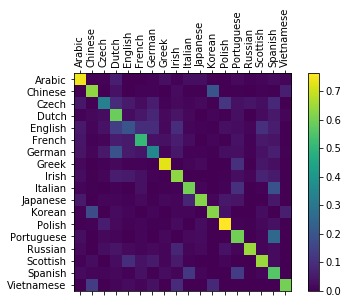

In [6]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
# 

# Running on User Input
# ---------------------
# 
